<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Прогнозирование биологического ответа:</span>

<span style="color:#6495ed">*Коротко о данных:*</span>

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

![](https://lms-cdn.skillfactory.ru/assets/courseware/v1/243fdc2d8abf9f176c01a429f1ae68ab/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/dst-3-ml-7-10.png)

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

<span style="color:#ff1e00">**Необходимо обучить две модели: логистическую регрессию и случайный лес.**</span>

В качестве метрики используется <span style="color:#ff1e00">**F1-score.**</span>

> Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

<center><p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Импорт библиотек и чтение датафрейма:</span>


In [1]:
# Импорт основных библиотек
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px 
import time

# Импорт модулей sklearn
from sklearn import linear_model, tree, ensemble, metrics, preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

# Импорт модулей hyperopt
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

# Импорт библиотеки optuna
import optuna

# Для распечатки в цвете:
from termcolor import colored

# Разгрузим выводы от ошибок
import warnings
warnings.filterwarnings("ignore")

# Немного зададим стиля графикам
%matplotlib inline
plt.style.use("fivethirtyeight")

C:\Users\xndrf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# загрузка данных
df = pd.read_csv('kaggle.csv')
df

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


Разница соотношений: 18.5%


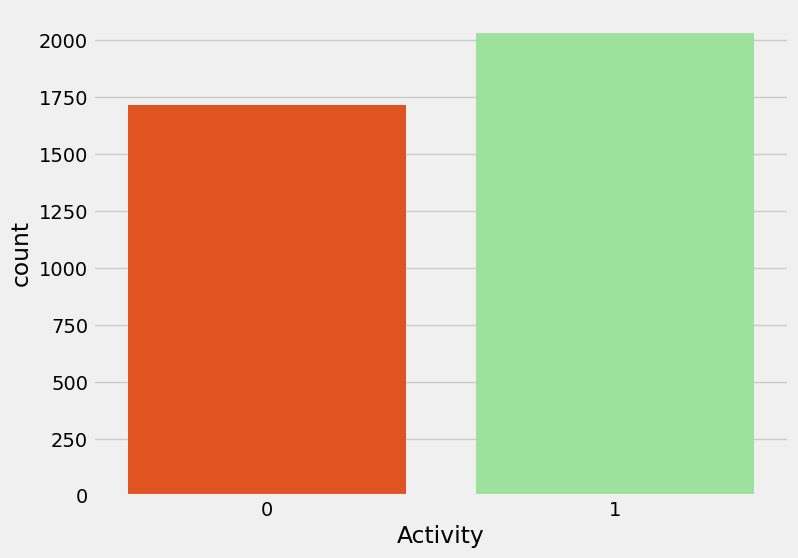

In [3]:
# Проверка на сбалансированность
plt.figure(figsize=(8, 6))
# sns.set_palette("bright")
sns.countplot(data=df, x='Activity', palette=['orangered', 'lightgreen'])
stratify_df = round((df['Activity'].value_counts()[1]/ df['Activity'].value_counts()[0]-1),3)*100
print(f'Разница соотношений: {stratify_df}%')

При обучении выставим значение признака с одинаковым соотношением на тренировочной и тестовой выборке

In [4]:
# Разделение выборки
X = df.drop(['Activity'], axis=1)
y = df['Activity'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

In [5]:
# Зафиксируем:
RS = 42 # random_state
MI = 50 # max_iter

# Создадим сборщик результатов обучения:
results_learn = []

<center><p style = "background-color : white; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">Соберем все функции и создадим единый реестровый ориентир по ним</span>

In [6]:
def o_metric(object_m, model_name, param, hp_time=None):
    """Функция вывода тренировочных и тестовых данных

    Args:
        object_m (object_m): Объект класса,
        model_name (str) : Название модели,
        param (grid_search): Оптимизация: 1) CV - GridSearchCV и RandomizedSearchCV;
                                          2) H - Hyperopt;
                                          3) O - Optune;
        hp_time(hp_time): Время подбора гиперпараметров.
        # Заметил, что много времени уходит на подбор гиперпараметров и захотелось взглянуть на эти цифры в общей таблице
    """

    start_time = time.time()  # Записываем текущее время перед обучением модели
    object_m.fit(X_train, y_train)

    print(colored(f'\n{model_name} результаты f1_score:', 'light_red'))
    y_train_pred = object_m.predict(X_train)
    m_train = metrics.f1_score(y_train, y_train_pred).round(3)
    print(colored(f"- Тренировочный набор: {m_train:.3f}", 'cyan'))
    y_test_pred = object_m.predict(X_test)
    m_test = metrics.f1_score(y_test, y_test_pred).round(3)
    print(colored(f"- Тестовый набор: {m_test:.3f}", 'cyan'))  

    end_time = time.time()  # Записываем текущее время после получения результатов
    execution_time = round(end_time - start_time, 3)  # Вычисляем время выполнения
    
    print(colored(f'\nВремя выполнения (секунд): {execution_time:.2f}', 'yellow'))

    # В случае использования  grid_search
    if param is None:
        pass
    elif param is 'CV':
        print(colored(f'\nНаилучшие значения гиперпараметров: {object_m.best_params_}', 'light_green'))
    elif param is 'H':
        print(colored(f'\nНаилучшие значения гиперпараметров: {best}', 'light_green'))
    elif param is 'O':
        print(colored(f'\nНаилучшие значения гиперпараметров: {study.best_params}', 'light_green'))
    else:
        print('Введено не верное значение param, Выставлено стандартное значение param = None\n',
            '1) CV - GridSearchCV и RandomizedSearchCV;\n',
            '2) H - Hyperopt;\n',
            '3) O - Optune.')

    # Сохраняем все данные
    results_learn.append({'model_name': model_name,
                          'train': m_train,
                          'test': m_test,
                          'time': execution_time,
                          'hyper_time': hp_time if hp_time is not None else 0})
    
    # Условия для времени подбора параметров и вывод информации
    if hp_time is None:
        pass
    else:
         try:
            print(colored(f'\nВремя подбора гиперпараметров (секунд): {hp_time:.2f}', 'yellow'))
         except ValueError:
                    print("Не правильно указана переменная hp_time")

In [7]:
# HYPEROPT LogisticRegression
def hyperopt_lg(params, cv=5, X=X_train, y=y_train, random_state=RS):
    """функция по HYPEROPT

    Args:
        params (params): параметры модели
    """    
    model = linear_model.LogisticRegression(**params, random_state=RS, max_iter=MI)
    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    return -score 

# HYPEROPT LogisticRegression cross_val_score
def hyperopt_lg_cross(params, cv=5, X=X_train, y=y_train, random_state=RS):
    model = linear_model.LogisticRegression(**params, random_state=RS, max_iter=MI)
    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

# HYPEROPT RandomForestClassifier
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RS):
    model = ensemble.RandomForestClassifier(**params, random_state=RS)
    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    return -score 

# HYPEROPT RandomForestClassifier cross_val_score
def hyperopt_rf_cross(params, cv=5, X=X_train, y=y_train, random_state=RS):
    model = ensemble.RandomForestClassifier(**params, random_state=RS)
    # обучаем модель
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()
    return -score

In [8]:
def optuna_opt(m_type, valid, trial):
    """Поиск гиперпараметров optuna

    Args:
        trial (trial): Логирование;
        m_type (str): Модель; (LR or RF)
        valid (_type_): Есть кроссвалидация или нет (N or Y).

    Returns:
        score
    """    
    if m_type == 'LR':
        penalty = trial.suggest_categorical('penalty', ['l2', None])
        solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
        C = trial.suggest_float('C', 0.1, 1.0)
        
        model = linear_model.LogisticRegression(
            penalty=penalty,
            solver=solver,
            C=C,
            random_state=RS,
            n_jobs=-1
        )

    elif m_type == 'RF':
        n_estimators = trial.suggest_int('n_estimators', 100, 310, step=10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7)
        max_depth = trial.suggest_int('max_depth', 15, 40)

        model = ensemble.RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_leaf=min_samples_leaf,
            random_state=RS,
            n_jobs=-1
        )

    else:
        raise ValueError("Invalid m_type, Выберите одну из:\n"
                         "1) LR - LogisticRegression;\n"
                         "2) RF - RandomForestClassifier.")

    model.fit(X_train, y_train)
    if valid == 'N':
        score = metrics.f1_score(y_test, model.predict(X_test))
    elif valid == 'Y':
        score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()
    else:
        raise ValueError("Invalid valid, Выберите одну из:\n"
                         "1) N - No crossvalid;\n"
                         "2) Y - Yes crossvalid.")

    return score

In [9]:
# Обобщим всё, на случай если забудем:
def_list = ['o_metric(object_m, model_name, param, hp_time=None)',
            'hyperopt_lg(params, cv=5, X=X_train, y=y_train, random_state=RS)',
            'hyperopt_lg_cross(params, cv=5, X=X_train, y=y_train, random_state=RS)',
            'hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RS)',
            'hyperopt_rf_cross(params, cv=5, X=X_train, y=y_train, random_state=RS)',
            'optuna_opt(m_type, valid, trial)']

<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression:</span>

In [10]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = MI)
o_metric(log_reg, 'LogisticRegression', None)


LogisticRegression результаты f1_score:
- Тренировочный набор: 0.871
- Тестовый набор: 0.786

Время выполнения (секунд): 0.17


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier:</span>

In [11]:
rf = ensemble.RandomForestClassifier(random_state=RS)
o_metric(rf, 'RandomForestClassifier', None)


RandomForestClassifier результаты f1_score:
- Тренировочный набор: 1.000
- Тестовый набор: 0.813

Время выполнения (секунд): 1.60


<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">GridSearchCV</span>

<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression:</span>

In [12]:
param_grid = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))}

time_s = time.time()
grid_search_LR = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RS, max_iter=MI), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1 
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_G_LR = round(time_e - time_s, 3)  # Вычисляем время выполнения

In [13]:
o_metric(grid_search_LR, 'GridSearchCV LogisticRegression', 'CV', hp_time_G_LR)


GridSearchCV LogisticRegression результаты f1_score:
- Тренировочный набор: 0.817
- Тестовый набор: 0.797

Время выполнения (секунд): 16.93

Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}

Время подбора гиперпараметров (секунд): 0.00


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier:</span>

In [14]:
param_grid = {'n_estimators': list(range(100, 500, 50)),
              'min_samples_leaf': [3,5,7],
              'max_depth': list(np.linspace(2, 40, 5, dtype=int))
              }

time_s = time.time()            
grid_search_RF = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=RS), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_G_RF = round(time_e - time_s, 3)  # Вычисляем время выполнения

o_metric(grid_search_RF, 'GridSearchCV RandomForestClassifier', 'CV', hp_time_G_RF)


GridSearchCV RandomForestClassifier результаты f1_score:
- Тренировочный набор: 0.977
- Тестовый набор: 0.824

Время выполнения (секунд): 83.56

Наилучшие значения гиперпараметров: {'max_depth': 21, 'min_samples_leaf': 3, 'n_estimators': 450}

Время подбора гиперпараметров (секунд): 0.00


<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">RandomizedSearchCV:</span>

<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression:</span>

In [15]:
param_distributions = {'penalty': ['l2', None] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}

time_s = time.time()                  
random_search_RF = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=RS, max_iter=MI), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_R_LR = round(time_e - time_s, 3)  # Вычисляем время выполнения

o_metric(random_search_RF, 'RandomizedSearchCV LogisticRegression', 'CV', hp_time_R_LR)


RandomizedSearchCV LogisticRegression результаты f1_score:
- Тренировочный набор: 0.851
- Тестовый набор: 0.786

Время выполнения (секунд): 14.98

Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}

Время подбора гиперпараметров (секунд): 0.00


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier:</span>

In [16]:
param_distributions = {'n_estimators': list(range(100, 500, 50)),
              'min_samples_leaf': [3,5,7],
              'max_depth': list(np.linspace(2, 40, 5, dtype=int))
              }

time_s = time.time()            
random_search_forest = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=RS), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 50, 
    n_jobs = -1
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_R_RF = round(time_e - time_s, 3)  # Вычисляем время выполнения
o_metric(random_search_RF, 'RandomizedSearchCV RandomForestClassifier', 'CV', hp_time_R_RF)


RandomizedSearchCV RandomForestClassifier результаты f1_score:
- Тренировочный набор: 0.851
- Тестовый набор: 0.786

Время выполнения (секунд): 14.77

Наилучшие значения гиперпараметров: {'solver': 'sag', 'penalty': 'l2', 'C': 0.12}

Время подбора гиперпараметров (секунд): 0.00


<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Hyperopt</span>

<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression:</span>

In [17]:
pen = [None, 'l2']
sol = ['lbfgs', 'sag']
C = np.arange(.1,1.1,.1)
space = {'penalty': hp.choice('penalty', pen),
        'solver' : hp.choice('solver', sol),
        'C': hp.choice('C', C)}

In [18]:
trials = Trials() # используется для логирования результатов

time_s = time.time()
best=fmin(hyperopt_lg, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RS)# фиксируем для повторяемости результата
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_H_LG = round(time_e - time_s, 3)  # Вычисляем время выполнения

100%|██████████| 20/20 [00:15<00:00,  1.27trial/s, best loss: -0.8775698066891685]


In [19]:
hyperopt_logistic = linear_model.LogisticRegression(
    random_state=RS, 
    penalty=pen[int(best['penalty'])],
    solver=sol[int(best['solver'])],
    C=C[int(best['C'])]
)

o_metric(hyperopt_logistic, 'Hyperopt LogisticRegression', 'H', hp_time_H_LG)


Hyperopt LogisticRegression результаты f1_score:
- Тренировочный набор: 0.910
- Тестовый набор: 0.755

Время выполнения (секунд): 0.22

Наилучшие значения гиперпараметров: {'C': 2, 'penalty': 0, 'solver': 0}

Время подбора гиперпараметров (секунд): 15.71


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression with cross validation:</span>

In [20]:
# cross
trials = Trials() # используется для логирования результатов
time_s = time.time()
best=fmin(hyperopt_lg_cross, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(RS)# фиксируем для повторяемости результата
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_H_LG_С = round(time_e - time_s, 3)  # Вычисляем время выполнения

100%|██████████| 20/20 [00:37<00:00,  1.85s/trial, best loss: -0.7817623180369621]


In [21]:
hyperopt_logistic_cross = linear_model.LogisticRegression(
    random_state=RS, 
    penalty=pen[int(best['penalty'])],
    solver=sol[int(best['solver'])],
    C=C[int(best['C'])]
)
o_metric(hyperopt_logistic_cross, 'Hyperopt LogisticRegression with cross validation', 'H', hp_time_H_LG_С)


Hyperopt LogisticRegression with cross validation результаты f1_score:
- Тренировочный набор: 0.849
- Тестовый набор: 0.790

Время выполнения (секунд): 2.77

Наилучшие значения гиперпараметров: {'C': 0, 'penalty': 1, 'solver': 1}

Время подбора гиперпараметров (секунд): 37.09


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier:</span>

In [22]:
n_estimators = np.arange(100, 500, 2, dtype = int)
max_depth = np.arange(15, 26, 1, dtype = int)
min_samples_leaf = np.arange(2, 11, 1, dtype=int)

# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.choice('n_estimators', n_estimators ),
       'max_depth' : hp.choice('max_depth', max_depth),
       'min_samples_leaf': hp.choice('min_samples_leaf', min_samples_leaf)
      }

In [23]:
trials = Trials()

time_s = time.time()
best = fmin(
    fn=hyperopt_rf,
    space = space, 
    algo=tpe.suggest, 
    max_evals=20, 
    trials=trials
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_H_RF = round(time_e - time_s, 3)  # Вычисляем время выполнения

100%|██████████| 20/20 [01:02<00:00,  3.12s/trial, best loss: -0.9773976786805131]


In [24]:
rf_Hyperopt = ensemble.RandomForestClassifier(
    random_state=RS, 
    n_estimators=n_estimators[int(best['n_estimators'])],
    max_depth=max_depth[int(best['max_depth'])],
    min_samples_leaf=min_samples_leaf[int(best['min_samples_leaf'])],
)
o_metric(rf_Hyperopt,'Hyperopt RandomForestClassifier', 'H', hp_time_H_RF)


Hyperopt RandomForestClassifier результаты f1_score:
- Тренировочный набор: 0.977
- Тестовый набор: 0.823

Время выполнения (секунд): 4.51

Наилучшие значения гиперпараметров: {'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 122}

Время подбора гиперпараметров (секунд): 62.50


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier with cross validation:</span>

In [25]:
trials = Trials()

time_s = time.time()
best = fmin(
    fn=hyperopt_rf_cross,
    space = space, 
    algo=tpe.suggest, 
    max_evals=20, 
    trials=trials
)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_H_RF_С = round(time_e - time_s, 3)  # Вычисляем время выполнения

100%|██████████| 20/20 [02:00<00:00,  6.05s/trial, best loss: -0.814994863687837] 


In [26]:
rf_Hyperopt_cross = ensemble.RandomForestClassifier(
    random_state=RS, 
    n_estimators=n_estimators[int(best['n_estimators'])],
    max_depth=max_depth[int(best['max_depth'])],
    min_samples_leaf=min_samples_leaf[int(best['min_samples_leaf'])],
)
o_metric(rf_Hyperopt_cross, 'Hyperopt RandomForestClassifier with cross validation', 'H', hp_time_H_RF_С)


Hyperopt RandomForestClassifier with cross validation результаты f1_score:
- Тренировочный набор: 0.989
- Тестовый набор: 0.818

Время выполнения (секунд): 3.59

Наилучшие значения гиперпараметров: {'max_depth': 3, 'min_samples_leaf': 0, 'n_estimators': 83}

Время подбора гиперпараметров (секунд): 120.94


<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Optuna</span>

<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression:</span>

In [27]:
# выводим результаты на обучающей выборке
time_s = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optuna_opt('LR', 'N', trial), n_trials=20)
model = linear_model.LogisticRegression(**study.best_params,random_state=RS)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_O_LR = round(time_e - time_s, 3)  # Вычисляем время выполнения

[I 2024-07-17 20:25:32,456] A new study created in memory with name: no-name-88990aa0-7f2b-4f03-b690-f70277ed238e
[I 2024-07-17 20:25:35,693] Trial 0 finished with value: 0.7788461538461539 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.4706856333441305}. Best is trial 0 with value: 0.7788461538461539.
[I 2024-07-17 20:25:37,359] Trial 1 finished with value: 0.7870036101083032 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.643111863866539}. Best is trial 1 with value: 0.7870036101083032.
[I 2024-07-17 20:25:39,007] Trial 2 finished with value: 0.7827130852340937 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.32938678211644834}. Best is trial 1 with value: 0.7870036101083032.
[I 2024-07-17 20:25:42,171] Trial 3 finished with value: 0.7788461538461539 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.5981711207821332}. Best is trial 1 with value: 0.7870036101083032.
[I 2024-07-17 20:25:44,831] Trial 4 finished with value: 0.784688995215311 and

In [28]:
o_metric(model,'Optuna LogisticRegression', 'O', hp_time_O_LR)


Optuna LogisticRegression результаты f1_score:
- Тренировочный набор: 0.877
- Тестовый набор: 0.790

Время выполнения (секунд): 3.38

Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'sag', 'C': 0.8479976926291043}

Время подбора гиперпараметров (секунд): 55.81


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">LogisticRegression with cross validation:</span>

In [29]:
time_s = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optuna_opt('LR', 'Y', trial), n_trials=20)
model = linear_model.LogisticRegression(**study.best_params,random_state=RS)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_O_LR_C = round(time_e - time_s, 3)  # Вычисляем время выполнения

[I 2024-07-17 20:26:31,677] A new study created in memory with name: no-name-0967d227-82e9-430f-aa65-9719b923eb7d
[I 2024-07-17 20:26:37,740] Trial 0 finished with value: 0.7665205856775353 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.10763839551748805}. Best is trial 0 with value: 0.7665205856775353.
[I 2024-07-17 20:26:40,413] Trial 1 finished with value: 0.7475536741581407 and parameters: {'penalty': None, 'solver': 'lbfgs', 'C': 0.8342353994474094}. Best is trial 0 with value: 0.7665205856775353.
[I 2024-07-17 20:26:45,512] Trial 2 finished with value: 0.7665205856775353 and parameters: {'penalty': None, 'solver': 'sag', 'C': 0.4051620096844578}. Best is trial 0 with value: 0.7665205856775353.
[I 2024-07-17 20:26:48,061] Trial 3 finished with value: 0.7794642423999079 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.24693983771682101}. Best is trial 3 with value: 0.7794642423999079.
[I 2024-07-17 20:26:54,461] Trial 4 finished with value: 0.7773958323184009 

In [30]:
o_metric(model,'Optuna LogisticRegression with cross validation', 'O', hp_time_O_LR_C)


Optuna LogisticRegression with cross validation результаты f1_score:
- Тренировочный набор: 0.850
- Тестовый набор: 0.788

Время выполнения (секунд): 0.24

Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'lbfgs', 'C': 0.10345219417611408}

Время подбора гиперпараметров (секунд): 75.76


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier:</span>

In [31]:
time_s = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optuna_opt('RF', 'N', trial), n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=RS)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_O_RF = round(time_e - time_s, 3)  # Вычисляем время выполнения

[I 2024-07-17 20:27:47,724] A new study created in memory with name: no-name-113dc625-89ad-4346-9fd9-ae535746ce4a
[I 2024-07-17 20:27:48,118] Trial 0 finished with value: 0.8263473053892215 and parameters: {'n_estimators': 240, 'min_samples_leaf': 3, 'max_depth': 33}. Best is trial 0 with value: 0.8263473053892215.
[I 2024-07-17 20:27:48,562] Trial 1 finished with value: 0.821301775147929 and parameters: {'n_estimators': 280, 'min_samples_leaf': 7, 'max_depth': 20}. Best is trial 0 with value: 0.8263473053892215.
[I 2024-07-17 20:27:48,975] Trial 2 finished with value: 0.8270142180094787 and parameters: {'n_estimators': 260, 'min_samples_leaf': 4, 'max_depth': 39}. Best is trial 2 with value: 0.8270142180094787.
[I 2024-07-17 20:27:49,434] Trial 3 finished with value: 0.8264462809917356 and parameters: {'n_estimators': 300, 'min_samples_leaf': 5, 'max_depth': 31}. Best is trial 2 with value: 0.8270142180094787.
[I 2024-07-17 20:27:49,767] Trial 4 finished with value: 0.8243727598566308

In [32]:
o_metric(model,'Optuna RandomForestClassifier', 'O', hp_time_O_RF)


Optuna RandomForestClassifier результаты f1_score:
- Тренировочный набор: 0.943
- Тестовый набор: 0.831

Время выполнения (секунд): 1.37

Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 17}

Время подбора гиперпараметров (секунд): 6.82


<p style = "background-color : gold; border-radius: 2px 2px; padding : 3px"><strong>
<span style="color:#000">RandomForestClassifier with cross validation:</span>

In [33]:
time_s = time.time()
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optuna_opt('RF', 'Y', trial), n_trials=20)
model = ensemble.RandomForestClassifier(**study.best_params,random_state=RS)
time_e = time.time()  # Записываем текущее время после получения результатов
hp_time_O_RF_C = round(time_e - time_s, 3)  # Вычисляем время выполнения

[I 2024-07-17 20:27:55,940] A new study created in memory with name: no-name-74efd7d4-bfc6-4cda-9f5c-a1dd0b680cb8
[I 2024-07-17 20:27:56,758] Trial 0 finished with value: 0.8051584732004293 and parameters: {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 19}. Best is trial 0 with value: 0.8051584732004293.
[I 2024-07-17 20:27:57,779] Trial 1 finished with value: 0.8006446698240822 and parameters: {'n_estimators': 180, 'min_samples_leaf': 6, 'max_depth': 31}. Best is trial 0 with value: 0.8051584732004293.
[I 2024-07-17 20:27:58,726] Trial 2 finished with value: 0.799697838341408 and parameters: {'n_estimators': 160, 'min_samples_leaf': 7, 'max_depth': 20}. Best is trial 0 with value: 0.8051584732004293.
[I 2024-07-17 20:27:59,818] Trial 3 finished with value: 0.8073958276649849 and parameters: {'n_estimators': 180, 'min_samples_leaf': 3, 'max_depth': 31}. Best is trial 3 with value: 0.8073958276649849.
[I 2024-07-17 20:28:00,896] Trial 4 finished with value: 0.8014619044812467

In [34]:
o_metric(model,'Optuna RandomForestClassifier with cross validation', 'O', hp_time_O_RF_C)


Optuna RandomForestClassifier with cross validation результаты f1_score:
- Тренировочный набор: 0.978
- Тестовый набор: 0.821

Время выполнения (секунд): 3.88

Наилучшие значения гиперпараметров: {'n_estimators': 300, 'min_samples_leaf': 3, 'max_depth': 37}

Время подбора гиперпараметров (секунд): 24.88


<p style = "background-color : red; border-radius: 5px 5px; padding : 2px"><strong>
<span style="color:#000">Код в качестве примера визуализация оптимизации optuna #закоментил#</span>

In [35]:
# optuna.visualization.is_available()

In [36]:
# optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [37]:
# optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [38]:
# optuna.visualization.plot_contour(study, params=["max_depth", "min_samples_leaf"],
#                                   target_name="f1_score")

<center><p style = "background-color : #59f068; border-radius: 5px 5px; padding : 10px"><strong>
<span style="color:#000">Создадим DataFrame из полученных результатов, визуализируем и подытожим полученные результаты</span>

In [39]:
results_learn = pd.DataFrame(results_learn)
results_learn

,model_name,train,test,time,hyper_time
0,LogisticRegression,0.871,0.786,0.170,0.000
1,RandomForestClassifier,1.000,0.813,1.599,0.000
2,GridSearchCV LogisticRegression,0.817,0.797,16.935,0.000
3,GridSearchCV RandomForestClassifier,0.977,0.824,83.562,0.000
4,RandomizedSearchCV LogisticRegression,0.851,0.786,14.977,0.000
5,RandomizedSearchCV RandomForestClassifier,0.851,0.786,14.767,0.000
6,Hyperopt LogisticRegression,0.910,0.755,0.216,15.709
7,Hyperopt LogisticRegression with cross validation,0.849,0.790,2.771,37.089
8,Hyperopt RandomForestClassifier,0.977,0.823,4.514,62.501
9,Hyperopt RandomForestClassifier with cross val...,0.989,0.818,3.591,120.938


In [40]:
#Отсортируем данные для лучшей наглядности
result_test = results_learn.sort_values(by='test')

# Построение графика
fig = px.bar(result_test,
             y='model_name',
             x=['train', 'test'],
             barmode='group',
             title = 'Сравнительный график f1_score моделей',
             width=1200,
             height=1000)

# Настройка осей графика:
fig.update_layout(
    title = dict(x = .5, xanchor = "center"),
    xaxis_title = "f1_score",
    yaxis_title="",
    margin=dict(l=0, r=0, t=30, b=0)
    )

# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="f1_score: %{x}", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=1.0,       # Толщина линии колонки
    opacity=0.75            # Прозрачность колонки
)

# Добавление сетки на график для улучшения визуального восприятия информации
fig.update_xaxes(showgrid=True, gridwidth=2, gridcolor='black')
# fig.update_yaxes(showgrid=True, gridwidth=2, gridcolor='black')

# Отображение графика
fig.show()

In [41]:
#Отсортируем данные для лучшей наглядности
result_time = results_learn.sort_values(by='time')

# Строим график
fig = px.bar(
    result_time,
    x = 'model_name',
    y = 'time',
    title = 'Сравнительный график времени обучения моделей',
    color = 'model_name',
    width=1500,
    height=1000
)

# Настройка осей графика:
fig.update_layout(
    title = dict(x = .5, xanchor = "center"),
    xaxis_title = "",
    yaxis_title="Время, сек",
    yaxis_tickformat=',.2f',
    margin=dict(l=0, r=0, t=30, b=0)
    )

# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="Время обучения: %{y} сек", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=2.5,       # Толщина линии колонки
    opacity=0.75            # Прозрачность колонки
)
fig.show();

In [42]:
#Отсортируем данные для лучшей наглядности
result_hyper = results_learn.sort_values(by='hyper_time')

# Строим график
fig = px.bar(
    result_hyper,
    x = 'model_name',
    y = 'hyper_time',
    title = 'Сравнительный график времени нахождения лучших гипперпараметров',
    color = 'model_name',
    width=1500,
    height=1000
)

# Настройка осей графика:
fig.update_layout(
    title = dict(x = .5, xanchor = "center"),
    xaxis_title = "",
    yaxis_title="Время, сек",
    yaxis_tickformat=',.2f',
    margin=dict(l=0, r=0, t=30, b=0)
    )

# Настройка информации при наведении курсора:
fig.update_traces(
    hovertemplate="Время нахождения лучших гипперпараметров: %{y} сек", #Информация при наведении курсора на колонку
    marker_line_color='black',   # Цвет линии колонки
    marker_line_width=2.5,       # Толщина линии колонки
    opacity=0.75            # Прозрачность колонки
)
fig.show();

Сравнительный график <span style="color:#ff0600">**f1_score**</span> показывает, что не всегда дополнительная оптимизация может улучшить модель, в некоторых местах даже привести к переобучению, поэтому необходимо сравнивать и анализировать с подбором наилучшей модели.

А вообще как вариант, при сборе всех данных, можно написать функцию, которая будет определять самый благоприятный тип модели для изучаемых данных. Возможно эти уже модели или функции есть, но на данном этапе обучения и основываясь на собственные знания сегодняшнего дня, предложил бы создать такую функцию, которая будет определять наименьшую процентную разницу между этими двумя показателями (<span style="color:#009cff">**train** и **test**</span>).

Визуально, могу предположить, что лучшие модели среди полученных, это те у которых train и test находятся практически с равным высоким результатом, выделим 5:

<span style="color:#00ff00">**1. GridSearchCV LogisticRegression;**</span>

<span style="color:#00ff00">**2. Hyperopt LogisticRegression with cross validation;**</span>

<span style="color:#00ff00">**3. Optuna LogisticRegression with cross validation;**</span>

<span style="color:#00ff00">**4. RandomizedSearchCV RandomForestClassifier;**</span>

<span style="color:#00ff00">**5. RandomizedSearchCV LogisticRegressionn.**</span>







При этом <span style="color:#00ff00">**GridSearchCV LogisticRegression**</span> требует много времени на обучение, но ему нет необходимости много затрачивать время на подбор лучших гиперпараметров, что сумарно в сравнении с методами <span style="color:#adff2f">**Hyperopt**</span> и <span style="color:#dc143c">**Optuna**</span> это хороший результат.

Поэтому в некоторых случаях стоит обратить внимание на то - а стоил ли заниматься <span style="color:#adff2f">**Hyperopt**</span> и <span style="color:#dc143c">**Optuna**</span> оптимизацией с поиском тех самых супер параметров для модели, есть ли у нас ресурс и время на это?

Стоит отметить момент, что cross validation не всегда может повысить качество модели, в некоторых моментах даже ухудшить результат, довести его до переобучения.

А также необходимо обратить внимание, что обычной <span style="color:#00fa9a">**LogisticRegressionn**</span> может хватить модели и, не всегда есть необходимость в дополнительных улучшениях.

**Касательно выбора лучшей модели:**

- Всё ситуативно; 
- Необходимо понимать требования заказчика;
- Грамотно распределять временные и энергетические ресурсы и т.д.

<span style="color:#00ffff">*Поэтому нельзя сказать, что необходимо выбирать определённый метод улучшения модели всегда*</span>

Можно представить данные как продукты, а методы улучшения моделей своего рода рецепты и в зависимости от блюда которое мы хотим получить на выходе, с каким вкусом и т.п. будем выбирать рецепт его приготовления.